In [42]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torch.utils.data import TensorDataset , DataLoader
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [2]:
# loading dataset 
df = pd.read_csv("C:/Users/gokup/Downloads/powerplant_data.csv")

In [3]:
df.head()

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


In [4]:
# AT >= Temperature 
# V  >= Vacume 
# AP >= Pressure
# RH >= Humidity 
# target   -- PE >= Produced Energy

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


In [6]:
df.isna().sum()

AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64

In [11]:
# Splitting our df 
x = df.drop("PE",axis=1)
y =df["PE"]

X_train , X_test , y_train , y_test = train_test_split(
    x , y, random_state=42 , test_size=0.2 
)

In [15]:
y_train.head()

5487    442.75
3522    432.52
6916    428.80
7544    426.07
7600    436.58
Name: PE, dtype: float64

In [17]:
# Scaling 

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)

In [19]:
# Converting df into tensor 

X_train_tensor = torch.tensor(x_train_scaled,dtype=torch.float32)
X_test_tensor = torch.tensor(x_test_scaled,dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values,dtype=torch.float32).view(-1,1)
y_test_tensor = torch.tensor(y_test.values,dtype=torch.float32).view(-1,1)

In [24]:
# Tensor Dataset | DataLoader 

train_dataset = TensorDataset(X_train_tensor , y_train_tensor)
test_dataset =  TensorDataset(X_test_tensor , y_test_tensor)

In [25]:
train_loader = DataLoader(train_dataset , batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset , batch_size=32)

## Deep Learning

In [37]:
# Defining our ANN Model / CLass 

class ANN(nn.Module):
    def __init__(self):
        super(ANN,self).__init__()

        self.model = nn.Sequential(
            # 1st hidden layer 
            nn.Linear(X_train.shape[1],6),
            nn.ReLU(),
    
            # 2nd hidden Layer
            nn.Linear(6,6),
            nn.ReLU(),
    
            # Output Layer
            nn.Linear(6,1),)

    def forward(self,x):
        return self.model(x)

In [38]:
# model -- 

model = ANN()

# loss , optimizers 

criterion  = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [39]:
# Training our ANN 

epochs = 100 
train_loss = []
val_loss = []
best_val_loss = float("inf")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for xb , yb in train_loader:
        optimizer.zero_grad()
        
        optput = model(xb)
        loss = criterion(optput,yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_train_loss = (running_loss/len(train_loader))
    train_loss.append(epoch_train_loss)


    # Validation -- 

    model.eval()
    running_val_loss = 0.0 

    with torch.no_grad():
        for xb, yb in test_loader:
            optputs = model(xb)
            loss = criterion(optputs,yb)
            running_val_loss+=loss.item()
            
    epoch_val_loss = running_val_loss/len(test_loader)
    val_loss.append(epoch_val_loss)

    print(f"epoch {epoch+1}/{epochs} ==> train loss = {epoch_train_loss} & val_loss = {epoch_val_loss}")

    if epoch_val_loss< best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(),"best_model.pt")

epoch 1/100 ==> train loss = 205184.67884114583 & val_loss = 201458.05703125
epoch 2/100 ==> train loss = 191788.28046875 & val_loss = 177017.71744791666
epoch 3/100 ==> train loss = 152856.68723958332 & val_loss = 124416.80533854167
epoch 4/100 ==> train loss = 95421.35206705729 & val_loss = 68573.49694010416
epoch 5/100 ==> train loss = 50601.32212727865 & val_loss = 36255.19537760417
epoch 6/100 ==> train loss = 28054.687390136718 & val_loss = 21191.95224609375
epoch 7/100 ==> train loss = 17558.316630045574 & val_loss = 14088.602587890626
epoch 8/100 ==> train loss = 12267.017014567058 & val_loss = 10030.752213541668
epoch 9/100 ==> train loss = 8789.079994710286 & val_loss = 7048.6734619140625
epoch 10/100 ==> train loss = 6062.871505737305 & val_loss = 4710.921069335937
epoch 11/100 ==> train loss = 3996.0425659179687 & val_loss = 3032.2605550130206
epoch 12/100 ==> train loss = 2584.9095087687174 & val_loss = 1960.6707244873046
epoch 13/100 ==> train loss = 1699.1869486490884 & 

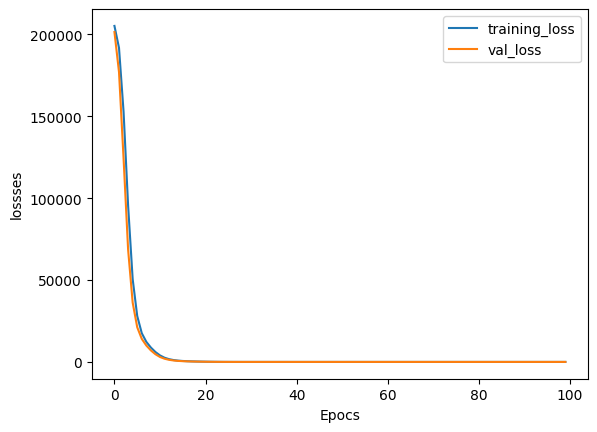

In [40]:
# plotting  our loss 

loss_df = pd.DataFrame({
    "Training_loss":train_loss,
    "Validation_loss":val_loss
})

plt.plot(loss_df["Training_loss"],label = "training_loss")
plt.plot(loss_df["Validation_loss"],label = "val_loss")

plt.xlabel("Epocs")
plt.ylabel('lossses')
plt.legend()
plt.show()

In [41]:
# load our best model 

model.load_state_dict(torch.load("best_model.pt"))

<All keys matched successfully>

In [46]:
# Evaluate our model 

model.eval()
with torch.no_grad():
    train_pred = model(X_train_tensor)
    test_pred = model(X_test_tensor)

    train_mse_loss = criterion(train_pred,y_train_tensor)
    test_mse_loss = criterion(test_pred,y_test_tensor)

print("Train_mse",train_mse_loss.item())
print("Test_mse",test_mse_loss.item())

print("r2_score",r2_score(test_pred,y_test))

Train_mse 20.45308494567871
Test_mse 18.773677825927734
r2_score 0.9306934923358664


In [47]:
#  comparision 

pred_df = pd.DataFrame(test_pred.numpy(),columns=["Pred val"])
act_df = pd.DataFrame(y_test.values,columns=["Act val"])
pd.concat([pred_df,act_df],axis=1)

,Pred val,Act val
0,435.155548,433.27
1,436.693787,438.16
2,460.985626,458.42
3,476.103912,480.82
4,434.842682,441.41
...,...,...
1909,451.337250,456.70
1910,431.392548,438.04
1911,467.780701,467.80
1912,430.781464,437.14
